In [3]:
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
import torch.nn.functional as F
from pyecharts.charts import HeatMap
from pyecharts import options as opts

In [4]:
# modity your save path here
data_dir = Path('/root/autodl-tmp/outputs/Qwen/QwQ-32B-Preview/aime')

In [5]:
# load result json
result_json_path = list(data_dir.glob('*.jsonl'))[0]
result_json = []
with open(result_json_path, 'r') as f:
    for line in f:
        result_json.append(json.loads(line.strip()))
result_json = result_json[1:-1]  # only this is valid

# get attention file path
attention_file_paths = list(data_dir.glob('*.pt'))

In [100]:
# function: load attention file (废弃版本，未考虑窗口截断对softmax的影响)
def visualization(filepath, idx, k, sigma=10):
    '''
    : filepath: attention文件具体位置
    : idx: 以第几个token为结尾
    : k: window长度
    : sigma: 缩放因子
    '''
    # 1. load data
    attention_result = torch.load(filepath)
    input_ids = attention_result['input_ids'][0]  # tensor (input_length)
    generated_ids = attention_result['generated_ids'][0]  # tensor (generated_length)
    input_tokens = attention_result['input_tokens']  # list (input_length), contains special token
    generated_tokens = attention_result['generated_tokens'][0]  # list (generated_length), contains special token
    print(f'Input token length: {len(input_tokens)} | Generated token length: {len(generated_tokens)}')

    # 2. 将attention展开
    all_tokens = input_tokens+generated_tokens  # correspond to the token which is assigned attention by generated token
    attentions_tag_token = [generated_tokens[0]]*len(input_tokens) + generated_tokens[1:]  # correspond to generated token
    attentions = []  # list (tensor (head_num, seq_length))
    for i, attn in enumerate(attention_result['attentions']):
        attn = attn.squeeze(0)
        if i==0:
            attentions.extend([t.squeeze(1) for t in torch.split(attn, 1, dim=1)])
        else:
            attentions.append(attn.squeeze(1))
            
    # 3. 取attention
    print(f'Your select {idx}th token: {all_tokens[idx]}')
    selected_attentions = []
    for i in range(idx-k+1, idx+1):
        pad_length = idx-i
        temp_attn = attentions[i][:, pad_length-k:]
        # 处理
        temp_attn = temp_attn.max(dim=0).values
        temp_attn = F.softmax(temp_attn)
        temp_attn = temp_attn*sigma
        temp_attn = temp_attn.tolist()
        # 填充
        temp_attn = temp_attn + [0] * pad_length
        selected_attentions.append(temp_attn)
    df = pd.DataFrame(selected_attentions, columns=all_tokens[idx-k+1:idx+1], index=attentions_tag_token[idx-k+1:idx+1])
    
    # 4. 可视化
    sns.heatmap(data=df)
    
    return df

In [101]:
# function: load attention file
def visualization(filepath, idx, k, sigma=1):
    '''
    : filepath: attention文件具体位置
    : idx: 以第几个token为结尾
    : k: window长度
    : sigma: 缩放因子
    '''
    # 1. load data
    attention_result = torch.load(filepath)
    input_ids = attention_result['input_ids'][0]  # tensor (input_length)
    generated_ids = attention_result['generated_ids'][0]  # tensor (generated_length)
    input_tokens = attention_result['input_tokens']  # list (input_length), contains special token
    generated_tokens = attention_result['generated_tokens'][0]  # list (generated_length), contains special token
    print(f'Input token length: {len(input_tokens)} | Generated token length: {len(generated_tokens)}')

    # 2. 将attention展开
    all_tokens = input_tokens+generated_tokens  # correspond to the token which is assigned attention by generated token
    attentions_tag_token = [generated_tokens[0]]*len(input_tokens) + generated_tokens[1:]  # correspond to generated token
    attentions = []  # list (tensor (head_num, seq_length))
    for i, attn in enumerate(attention_result['attentions']):
        attn = attn.squeeze(0)
        if i==0:
            attentions.extend([t.squeeze(1) for t in torch.split(attn, 1, dim=1)])
        else:
            attentions.append(attn.squeeze(1))
            
    # 3. 取attention
    print(f'Your select {idx}th token: {all_tokens[idx]}')
    selected_attentions = []
    for i in range(idx-k+1, idx+1):
        pad_length = idx-i
        temp_attn = attentions[i][:, -k:]
        # 处理
        temp_attn = temp_attn.max(dim=0).values
        temp_attn = F.softmax(temp_attn)
        temp_attn = temp_attn*sigma
        temp_attn = temp_attn[pad_length-k:]
        temp_attn = temp_attn.tolist()
        # 填充
        temp_attn = temp_attn + [0] * pad_length
        selected_attentions.append(temp_attn)
    df = pd.DataFrame(selected_attentions, columns=all_tokens[idx-k+1:idx+1], index=attentions_tag_token[idx-k+1:idx+1])
    
    # 4. 可视化
    sns.heatmap(data=df)
    
    return df

Input token length: 161 | Generated token length: 1812
Your select 361th token: )


/tmp/ipykernel_2409/3531850087.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  temp_attn = F.softmax(temp_attn)


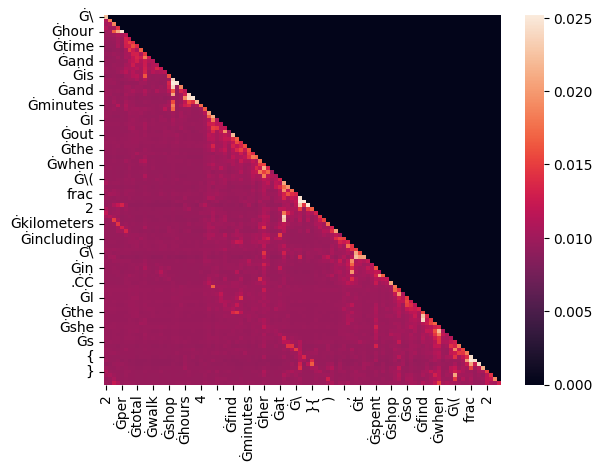

In [102]:
temp = visualization(data_dir.joinpath('test_qwen-instruct_t0_n1_s0_e-160_attentions.pt'), 361, 100)

Input token length: 104 | Generated token length: 6397
Your select 234th token: Ġdegrees


/tmp/ipykernel_2409/3531850087.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  temp_attn = F.softmax(temp_attn)


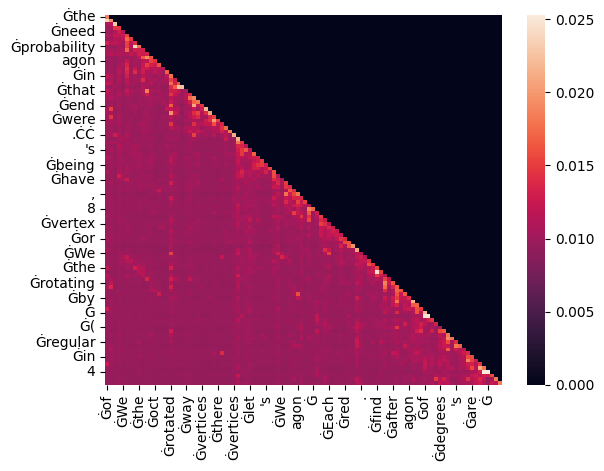

In [103]:
temp = visualization(data_dir.joinpath('test_qwen-instruct_t0_n1_s0_e-162_attentions.pt'), 234, 100)

In [57]:
len(temp)

1972

In [59]:
temp[-1].shape

torch.Size([40, 1972])